# Forward Feature Selection

The purpose of this notebook is to perform forward feature selection, starting from the importance scores given by the RF feature selection performed in another notebook. The clustering algorithm tested is DBSCAN and the goal is to maximize V-Measure, minimizing RMSE

## Libraries and Configurations

Import configuration files

In [443]:
from configparser import ConfigParser

config = ConfigParser()
config.read("../config.ini")

['../config.ini']

Import **data libraries**

In [444]:
import pandas as pd

Import **other libraries**

In [445]:
from rich.progress import Progress
from rich import traceback

traceback.install()

<bound method InteractiveShell.excepthook of <ipykernel.zmqshell.ZMQInteractiveShell object at 0x728a6c15bc10>>

Custom helper scripts

In [446]:
%cd ..
from scripts import plotHelper, encodingHelper
%cd data_exploration_cleaning

/home/bacci/COMPACT/notebooks
/home/bacci/COMPACT/notebooks/data_exploration_cleaning


## Feature Importance

In [447]:
feature_importances_csv = (
    config["DEFAULT"]["reports_path"]
    + "CSV/feature_selection/DISSECTED_importances_RF.csv"
)

feature_importances = pd.read_csv(feature_importances_csv).sort_values(
    by=["Importance"], ascending=False
)

These are the features selected by the Random Forest classifier, with the goal of correctly classifying the `Label` column. They are sorted according to the importance given, descending.

In [448]:
feature_importances

,Feature,Importance
3,Length,0.151389
2,Vendor Specific Tags,0.110161
21,Min_MPDCU_Start_Spacing,0.070928
23,RX_Highest_Supported_Data_Rate,0.047190
40,Interworking,0.044109
42,WNM_Notification,0.031174
13,DSSS_CCK,0.030882
41,QoS_Map,0.029089
30,Extended_Channel_Switching,0.028832
18,SM_Power_Save,0.027387


## Import Data

In [449]:
# Combined dataframe
burst_csv = config["DEFAULT"]["interim_path"] + "dissected/std_burst_dissected_df.csv"

In [450]:
df = pd.read_csv(burst_csv, index_col=0)

We remove `MAC Address` column, since it is not used for the feature selection

In [451]:
df = df.drop(columns=["MAC Address"])

Removing a couple of devices to check if the results are overfit

In [452]:
# df = df[
#     (df["Label"] != "iPhone11_B")
#     & (df["Label"] != "iPhone11_C")
#     & (df["Label"] != "iPhone11_F")
#     & (df["Label"] != "iPhone12_W")
# ]

## Normalize Data

In [453]:
df.fillna("-1", inplace=True)

/tmp/ipykernel_9772/4038702002.py:1: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '-1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("-1", inplace=True)


In [454]:
from sklearn.preprocessing import MinMaxScaler

In [455]:
from sklearn.preprocessing import MinMaxScaler

# Select the numeric columns
numeric_columns = df.loc[:, df.columns != "Label"].columns

# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Normalize the numeric columns
df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

df_normalized = df.copy()

In [456]:
df_normalized.fillna("-1", inplace=True)

In [457]:
df_normalized

,Channel,DS Channel,Vendor Specific Tags,Length,Label,Supported Rates 1,Supported Rates 2,Supported Rates 3,Supported Rates 4,Extended Supported Rates 1,...,TIM_Broadcast,BSS_Transition,Multiple_BSSID,Timing_Measurement,SSID_List,DMS,Interworking,QoS_Map,WNM_Notification,Operating_Mode_Notification
0,0.0,0.000000,0.032258,1.000000,SamsungJ6_K,1.0,1.0,1.0,1.0,0.0,...,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,1.0,0.714286,0.177419,0.287671,SamsungM31_A,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,0.5,0.5,0.5,0.5,0.5,0.5,0.5,1.0
3,1.0,0.857143,1.000000,0.328767,iPhone11_C,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0
4,1.0,0.785714,1.000000,0.328767,iPhone11_B,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0
5,0.0,0.285714,1.000000,0.378995,iPhone12_W,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4410,1.0,0.857143,1.000000,0.324201,iPhone12_W,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0
4411,0.5,0.142857,0.016129,0.438356,iPhone6_N,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.5,0.5,0.5,1.0,1.0,0.5,0.5,1.0
4412,0.0,0.142857,1.000000,0.328767,iPhone11_C,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0
4413,0.0,0.214286,1.000000,0.378995,iPhone12_W,1.0,1.0,1.0,1.0,0.0,...,1.0,1.0,0.5,0.5,0.5,1.0,0.5,0.5,0.5,1.0


In [458]:
df_normalized.dtypes

Channel                                                float64
DS Channel                                             float64
Vendor Specific Tags                                   float64
Length                                                 float64
Label                                                   object
Supported Rates 1                                      float64
Supported Rates 2                                      float64
Supported Rates 3                                      float64
Supported Rates 4                                      float64
Extended Supported Rates 1                             float64
Extended Supported Rates 2                             float64
Extended Supported Rates 3                             float64
Extended Supported Rates 4                             float64
Forty_Mhz_Intolerant                                   float64
DSSS_CCK                                               float64
Max_A_MSDU                                             

## Split Columns

In [459]:
X = df_normalized.drop(columns=["Label"])
y = df_normalized["Label"]

## Forward Feature Selection

In [460]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

In [461]:
remaining_features = feature_importances["Feature"].to_list()

In [462]:
print("Remaining features", remaining_features)

Remaining features ['Length', 'Vendor Specific Tags', 'Min_MPDCU_Start_Spacing', 'RX_Highest_Supported_Data_Rate', 'Interworking', 'WNM_Notification', 'DSSS_CCK', 'QoS_Map', 'Extended_Channel_Switching', 'SM_Power_Save', 'Operating_Mode_Notification', 'DMS', 'WNM_Sleep_Mode', 'SSID_List', 'RX_MSC_Bitmask', 'Tx_STBC', 'TFS', 'LDPC_Coding_Capability', 'Supported_Channel_Width', 'FMS', 'DS Channel', '20_40_BSS_Coexistence_Management_Support', 'TIM_Broadcast', 'Compressed_Steering_n_Beamformer_Antennas_Supported', 'Forty_Mhz_Intolerant', 'Short_GI_40Mhz', 'Supported Rates 4', 'BSS_Transition', 'Supported Rates 2', 'Rx_STBC', 'Supported Rates 3', 'Supported Rates 1', 'Extended Supported Rates 4', 'Channel', 'Extended Supported Rates 3', 'Extended Supported Rates 2', 'Multiple_BSSID', 'Timing_Measurement', 'Max_A_MPDU_Length_Exponent', 'Extended Supported Rates 1', 'MCS_Feedback', 'Max_A_MSDU', 'HTC_HT_Support', 'RD_Responder']


In [463]:
eps = 0.0001
min_samples = 20

In [464]:
from math import sqrt

selected_features = []
candidate_features = []
best_homogeneity = 0
best_completeness = 0
best_rmse = 100

candidate_features = selected_features.copy()

for feature_idx in range(len(remaining_features)):

    candidate_features.append(remaining_features[feature_idx])
    X_selected = X[candidate_features]

    # Train DBSCAN model
    dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)
    clusters = dbscan_model.fit_predict(X_selected)

    # Calculate homogeneity and completeness
    homogeneity = metrics.homogeneity_score(y, clusters)
    completeness = metrics.completeness_score(y, clusters)
    v_measure = metrics.v_measure_score(y, clusters)
    true_labels = len(set(y))
    detected_clusters = len(set(clusters))
    rmse = sqrt((true_labels - detected_clusters) ** 2)

    # Check for improvement
    if homogeneity > best_homogeneity and rmse < best_rmse:
        best_homogeneity = homogeneity
        best_completeness = completeness
        best_v_measure = v_measure
        best_rmse = rmse
        best_selected_features_list = candidate_features
        print("[!!!] New best")

        # Update remaining features
        print(candidate_features)
        print("\t Homogeneity", homogeneity)
        print("\t Completeness", completeness)
        print("\t RMSE", rmse)

[!!!] New best
['Length']
	 Homogeneity 0.7920173252986871
	 Completeness 0.8692966637283166
	 RMSE 7.0
[!!!] New best
['Length', 'Vendor Specific Tags']
	 Homogeneity 0.8117141682245851
	 Completeness 0.8505333616693972
	 RMSE 1.0
[!!!] New best
['Length', 'Vendor Specific Tags', 'Min_MPDCU_Start_Spacing']
	 Homogeneity 0.8182049248648731
	 Completeness 0.8515430424950199
	 RMSE 0.0


In [465]:
print("Best Homogeneity", best_homogeneity)
print("Best Completeness", best_completeness)
print("Best V-Measure", best_v_measure)
print("Best RMSE:", best_rmse)

Best Homogeneity 0.8182049248648731
Best Completeness 0.8515430424950199
Best V-Measure 0.83454116995331
Best RMSE: 0.0


In [466]:
best_features = [
    "Length",
    "Vendor Specific Tags",
    "Min_MPDCU_Start_Spacing",
    # "RX_Highest_Supported_Data_Rate",
    # "Interworking",
    # "WNM_Notification",
    # "DSSS_CCK",
    # "QoS_Map",
    # "Extended_Channel_Switching",
]

In [467]:
len(best_features)

3

Let's see how the dataframe is looking, considering only the `best_features`

## Final Clustering w/ Metrics

In [468]:
from sklearn.metrics import homogeneity_completeness_v_measure
from math import sqrt

In [469]:
best_df = df_normalized[best_features].copy()
best_df["Label"] = df_normalized["Label"]

In [470]:
best_df

,Length,Vendor Specific Tags,Min_MPDCU_Start_Spacing,Label
0,1.000000,0.032258,0.125,SamsungJ6_K
2,0.287671,0.177419,0.750,SamsungM31_A
3,0.328767,1.000000,0.875,iPhone11_C
4,0.328767,1.000000,0.875,iPhone11_B
5,0.378995,1.000000,0.875,iPhone12_W
...,...,...,...,...
4410,0.324201,1.000000,0.875,iPhone12_W
4411,0.438356,0.016129,0.750,iPhone6_N
4412,0.328767,1.000000,0.875,iPhone11_C
4413,0.378995,1.000000,0.875,iPhone12_W


In [471]:
final_clusterer = DBSCAN(eps=eps, min_samples=min_samples).fit(
    best_df.drop(columns=["Label"])
)
best_df["Cluster"] = final_clusterer.labels_

In [472]:
best_df

,Length,Vendor Specific Tags,Min_MPDCU_Start_Spacing,Label,Cluster
0,1.000000,0.032258,0.125,SamsungJ6_K,-1
2,0.287671,0.177419,0.750,SamsungM31_A,-1
3,0.328767,1.000000,0.875,iPhone11_C,0
4,0.328767,1.000000,0.875,iPhone11_B,0
5,0.378995,1.000000,0.875,iPhone12_W,1
...,...,...,...,...,...
4410,0.324201,1.000000,0.875,iPhone12_W,3
4411,0.438356,0.016129,0.750,iPhone6_N,4
4412,0.328767,1.000000,0.875,iPhone11_C,0
4413,0.378995,1.000000,0.875,iPhone12_W,1


In [473]:
h, c, v = homogeneity_completeness_v_measure(best_df["Label"], best_df["Cluster"])
print("Homogeneity: \t", h)
print("Completeness: \t", c)
print("V-measure: \t", v)

Homogeneity: 	 0.8182049248648731
Completeness: 	 0.8515430424950199
V-measure: 	 0.83454116995331


In [474]:
true_labels = len(set(y))
detected_clusters = best_df["Cluster"].nunique()
rmse = sqrt((true_labels - detected_clusters) ** 2)
print("RMSE:", rmse)

RMSE: 0.0


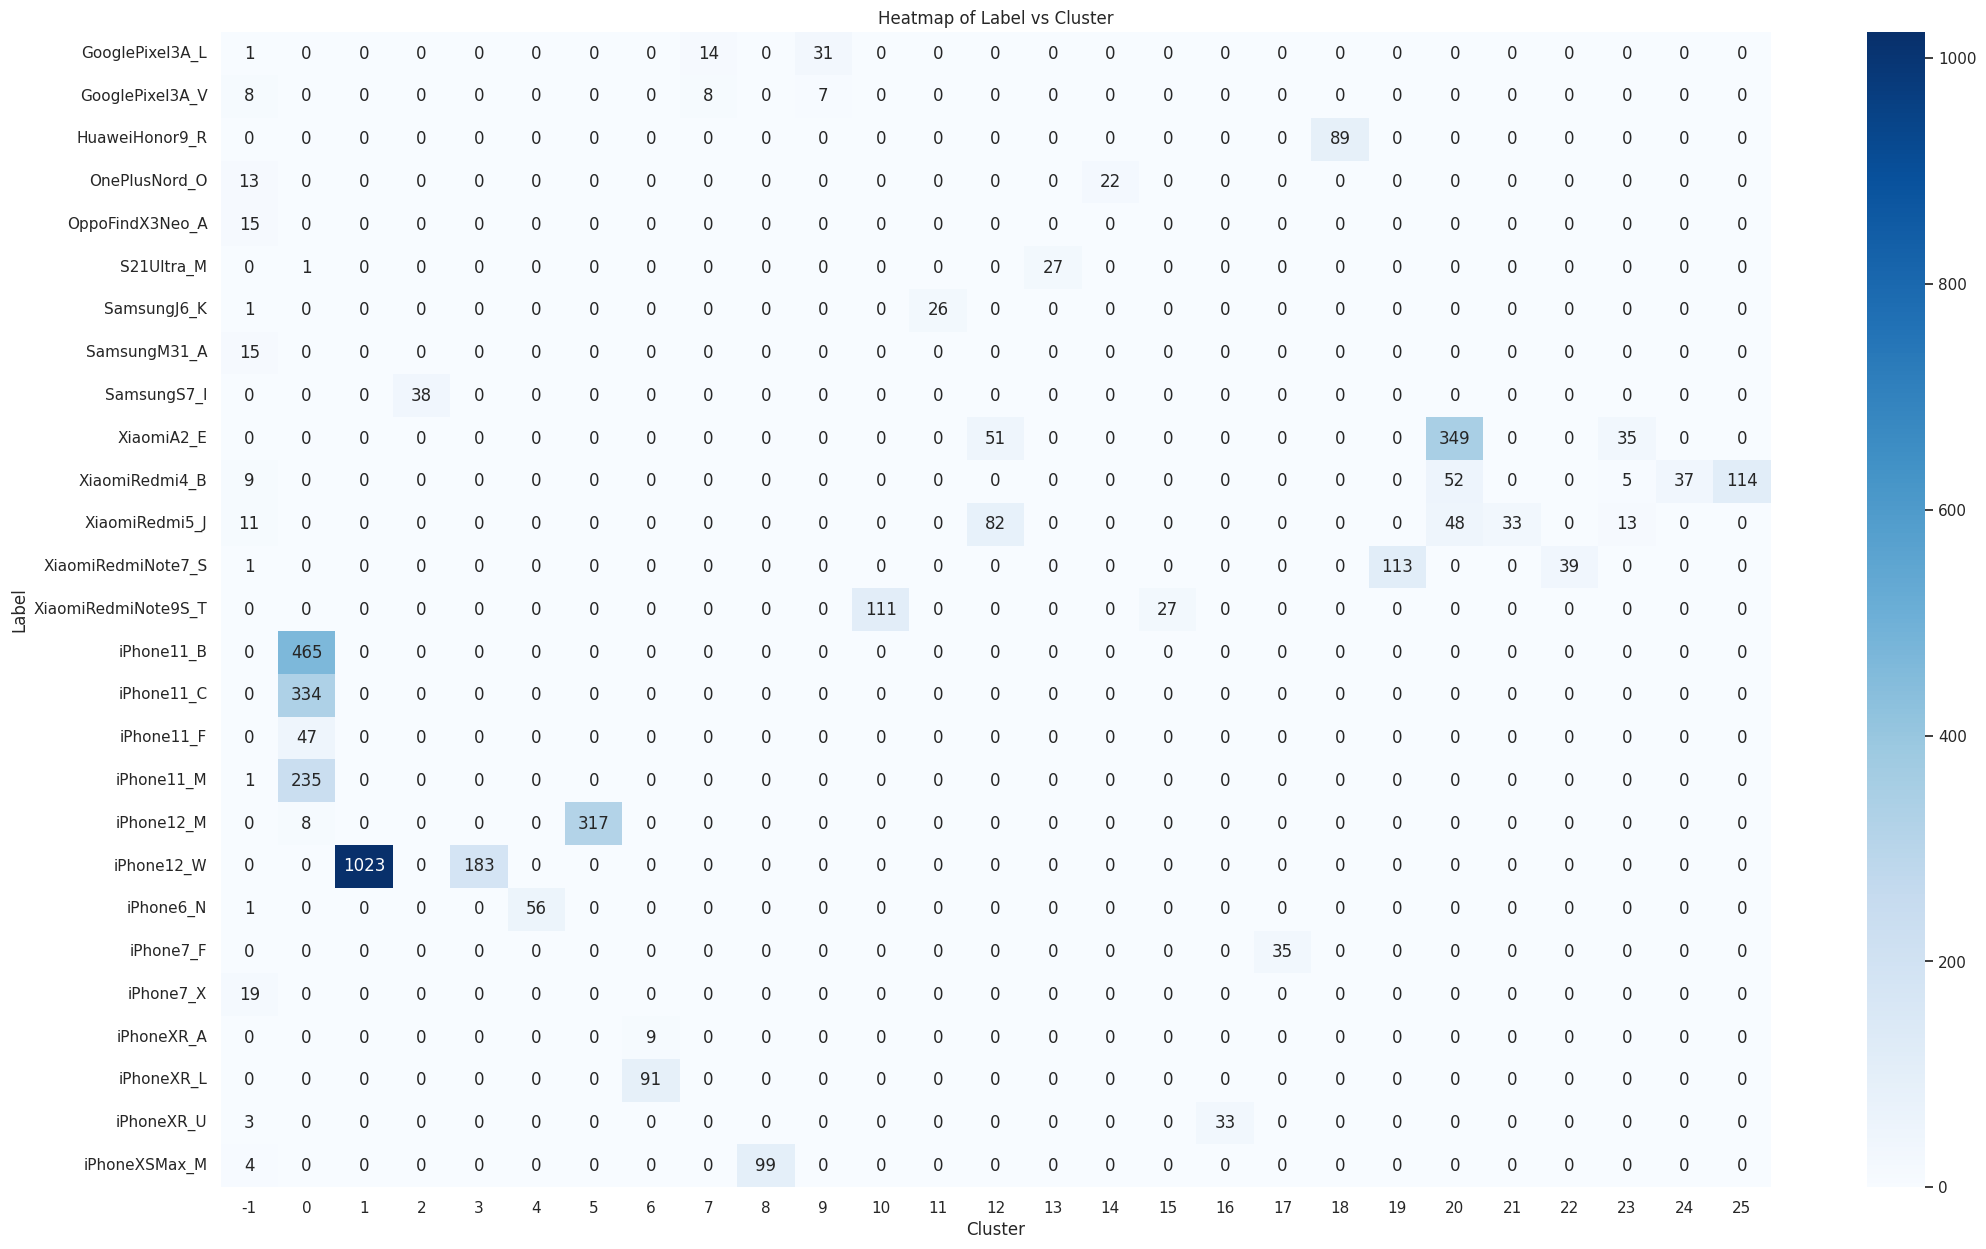

In [475]:
plotHelper.plot_heatmap(best_df, "Label", "Cluster")

In [476]:
print("Number of devices", best_df["Label"].nunique())

Number of devices 27
